In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier, cv, Dataset, train, plot_importance, LGBMRegressor
import re
import datetime
from sklearn.preprocessing import LabelEncoder
%pylab inline
from util import *
import pickle
from sklearn.model_selection import ParameterGrid, StratifiedKFold, cross_val_score, KFold
from tqdm import tqdm
import scipy.stats
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize, StandardScaler
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import clone
from dateutil.relativedelta import relativedelta
import json
from dask.multiprocessing import get
import re
from collections import defaultdict
from xgboost import XGBClassifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Data loading, base preprocessing in module util.py
df = load('train.csv')
Y = df.groupby('cl_id')['target_flag'].first()
Y_reg = df.groupby('cl_id')['target_sum'].first()

/home/light/Projects/kaggle/rosbank/util.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  df = pd.concat([df, pd.DataFrame(date_spaces)])


In [3]:
# Prepare table for parallel computation
df_dask = dd.from_pandas(df, npartitions=8)
trx_categories = df['trx_category'].unique()

In [4]:
# Test dataframe data loading, preprocessing and preparation for parallel computing
test = dd.from_pandas(load('test.csv'), npartitions=8)

/home/light/Projects/kaggle/rosbank/util.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  df = pd.concat([df, pd.DataFrame(date_spaces)])


In [5]:
def cl_features(d):
    """
    Feature preparation
        arg: d - pd.DataFrame - Frame for each customer
    """
    result = dict()
    trx_categories = ['POS', 'DEPOSIT', 'CACH_OUT']
    test_mode = d['trx_category'].iloc[0] == 'foo'
    d = d.sort_values('TRDATETIME')
    if 'target_flag' in d.columns:
        result['target_flag'] = d.iloc[0]['target_flag']
        result['target_sum'] = d.iloc[0]['target_sum']
    
    # Time features
    min_pos = d['day'][d['trx_category']=='POS'].min()
        
    result['cl_id'] = d.iloc[0]['cl_id']
    
    result['min_month'] = d['month'].min()
    result['max_month'] = d['month'].max()
        
    result['month_diff'] = result['max_month']-result['min_month']
    result['min_day'] = d['day'].min()
    result['max_day'] = d['day'].max()
    result['day_diff'] = result['max_day']-result['min_day']
        
    min_hour = 2
    max_hour = 23
    result['night'] = ((d['hour']<=min_hour)| (d['hour']>=max_hour)).sum()/(((d['hour']>min_hour)& (d['hour']<max_hour)).sum()+1)
    result['night2'] = (((d['hour']>0) & (d['hour']<=min_hour))| (d['hour']>=max_hour)).sum()/(((d['hour']>min_hour)& (d['hour']<23)).sum()+1)

    result['full_night'] = (d['hour']==0).sum()
    result['mean_day'] = d['day'].mean()
    
    d['day_d'] = d['day']-result['min_day']
    result['day_std'] = d['day_d'].std()
    result['start_day_calendar'] = d['TRDATETIME'].min().day
    result['end_day_calendar'] = d['TRDATETIME'].max().day
    result['3_months2'] = d['TRDATETIME'].min()+relativedelta(months=3)>d['TRDATETIME'].max()
    
    amounts = defaultdict(list)
    counts = defaultdict(list)
    # By month calendar
    for i in range(5):
        start = result['min_month']+i
        end = result['min_month']+i+1
        
        last_n = d[['trx_category', 'amount', 'month', 'MCC', 'MCC_group', 'TRDATETIME']][((d['month']>=start)&(d['month']<end))]
        
        result[f'month_mcc_unique_{i}'] = len(last_n['MCC'].unique())
        result[f'month_trx_cat_unique_{i}'] = len(last_n['trx_category'].unique())
        
        user_trx_categories = last_n['trx_category'].value_counts()
        user_trx_categories_amount = last_n.groupby('trx_category')['amount'].sum()
        
        for trx_category in trx_categories:
            result[f'trx_category_{i}'+trx_category] = user_trx_categories.get(trx_category, 0)
            result[f'trx_category_amount_{i}'+trx_category] = user_trx_categories_amount.get(trx_category, 0)
            
            counts[trx_category].append(user_trx_categories.get(trx_category, 0))
            amounts[trx_category].append(user_trx_categories_amount.get(trx_category, 0))
            
        result['month_count_'+str(i)] = last_n.shape[0]
        result['month_amountsum_'+str(i)] = last_n['amount'].sum()
        result['dep_wd'] = last_n['amount'][last_n['trx_category']=='CACH_OUT'].sum() - last_n['amount'][last_n['trx_category']=='DEPOSIT'].sum()
        
        # By all period
        if i==0:
            end = 10**6
            last_n = d[['trx_category', 'amount', 'month']][((d['month']>=start)&(d['month']<end))]
            result['month_count2_'+str(i)] = last_n.shape[0]
            result['month_amountsum2_'+str(i)] = last_n['amount'].sum()


            user_trx_categories = last_n['trx_category'].value_counts()
            user_trx_categories_amount = last_n.groupby('trx_category')['amount'].mean()
            
            for trx_category in trx_categories:
                result['trx_category2_{i}'+trx_category] = user_trx_categories.get(trx_category, 0)
                result['trx_category_amount2_{i}'+trx_category] = user_trx_categories_amount.get(trx_category, 0)
    
    # Index of max value in array
    for key, value in amounts.items():
        result[f'max_{key}_amount_month'] = np.argmax(value)
        
    # Index of max value in array
    for key, value in counts.items():
        result[f'max_{key}_count_month'] = np.argmax(value)
                
    # Last month
    min_pos_date = d['TRDATETIME'][d['trx_category']=='POS'].min()
    start = min_pos_date+relativedelta(months=2) if not test_mode else datetime.datetime.now()
    end = min_pos_date+relativedelta(months=4) if not test_mode else datetime.datetime.now()

    last_n = d[['trx_category', 'amount', 'month', 'MCC', 'MCC_group']][((d['TRDATETIME']>=start)&(d['TRDATETIME']<end))]
    result[f'month_mcc_unique3'] = len(last_n['MCC'].unique())
    
    user_trx_categories = last_n['trx_category'].value_counts()
    user_trx_categories_amount = last_n.groupby('trx_category')['amount'].sum()
    
    for trx_category in trx_categories:
        result[f'trx_category3'+trx_category] = user_trx_categories.get(trx_category, 0)
        result[f'trx_category_amount3'+trx_category] = user_trx_categories_amount.get(trx_category, 0)

    result['month_count3'] = last_n.shape[0]
    result['month_amountsum3'] = last_n['amount'].sum()
    
    # Last N transactions
    for r in [15, 30]:
        last_n = d.tail(r)
        user_trx_categories = last_n['trx_category'].value_counts()
        user_trx_categories_amount = last_n.groupby('trx_category')['amount'].sum()
        
        for trx_category in trx_categories:
            result[f'trx_category6_{r}'+trx_category] = user_trx_categories.get(trx_category, 0)
            result[f'trx_category_amount6_{r}'+trx_category] = user_trx_categories_amount.get(trx_category, 0)
        
    # By transaction type - time features
    
    result['has_deposit'] = (d['trx_category']=='DEPOSIT').sum()>0
    for c in trx_categories:
        dd = d['day'][d['trx_category']==c]
        dt = d['TRDATETIME'][d['trx_category']==c]
        dm = d['month'][d['trx_category']==c]
        da = d['amount'][d['trx_category']==c]
        
        not_empty = dd.shape[0]>0
    
        result[f'min_day_{c}'] = dd.min() if not_empty else -1
        result[f'max_day_{c}'] = dd.max() if not_empty else -1
        result[f'day_diff_{c}'] = result[f'max_day_{c}'] - result[f'min_day_{c}'] if not_empty else -1
        
        result[f'min_month_{c}'] = dm.min() if not_empty else -1
        result[f'max_month_{c}'] = dm.max() if not_empty else -1
        
        result[f'month_diff_{c}'] = result[f'max_month_{c}'] - result[f'min_month_{c}'] if not_empty else -1
        dd -= result[f'min_day_{c}']
        result[f'day_std_{c}'] = dd.std() if not_empty else -1
         
    if not test_mode:
        d = d.loc[d['day']>=min_pos]
        
    # Index of transaction with Max amount by category
    result['3_months'] = (d['TRDATETIME'].max()-d['TRDATETIME'].min()).days>=90
    min_day = d['day'].min()
    pos_tr = d.loc[d['trx_category']=='POS']
    result['pos_sum'] = pos_tr['amount'].sum()
    max_pos_index = pos_tr['amount'].idxmax() if not test_mode else 0
    result['max_day_idx_pos'] = pos_tr.loc[max_pos_index]['day']-min_day if not test_mode else 0
    
    out_tr = d.loc[d['trx_category'].isin(['CACH_OUT', 'WD_ATM_PARTNER', 'WD_ATM_ROS', 'WD_ATM_OTHER'])]
    max_out_index = out_tr['amount'].idxmax() if out_tr.shape[0]>0 else -1
    result['max_day_idx_out'] = out_tr.loc[max_out_index]['day']-min_pos if out_tr.shape[0]>0 else -1
    
    return pd.Series(result)

def features(df):
    agg = df.groupby('cl_id').apply(lambda x: cl_features(x)).fillna(0)
    if 'target_flag' in agg.columns:
        return agg.drop(['target_flag', 'target_sum'], 1), agg['target_flag'], agg['target_sum']
    return agg

X, _, _ = features(df_dask)

/home/light/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:150: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


In [7]:
# Real code execution
X = X.compute(get=get).sort_values('cl_id').sort_values('cl_id')

/home/light/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'cl_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [8]:
# Removing outliers. No improvements on private score
not_outliers = np.where(Y_reg<np.exp(14))[0]
X2 = X.copy().iloc[not_outliers]
Y2 = Y.copy().iloc[not_outliers]
Y2_reg = Y_reg.copy().iloc[not_outliers]

In [9]:
# Кросс валидация
params = {'bagging_fraction': 0.55, 'bagging_freq': 2, 'colsample_bytree': 0.8, 
          'learning_rate': 0.01, 'max_bin': 255, 'max_depth': -1, 'metric': 'auc', 
          'min_data_in_leaf': 20, 'num_leaves': 16, 'objective': 'binary', 'reg_alpha': 0.4,
          'reg_lambda': 0.55, 'verbose': -1
         }

_ = cv(params, Dataset(X2, Y2), verbose_eval=False, 
       seed=4, num_boost_round=2000, early_stopping_rounds=100, nfold=10
      )
print(max(_['auc-mean']))
print(np.array(_['auc-mean']).argmax())

0.8823952017427107
767


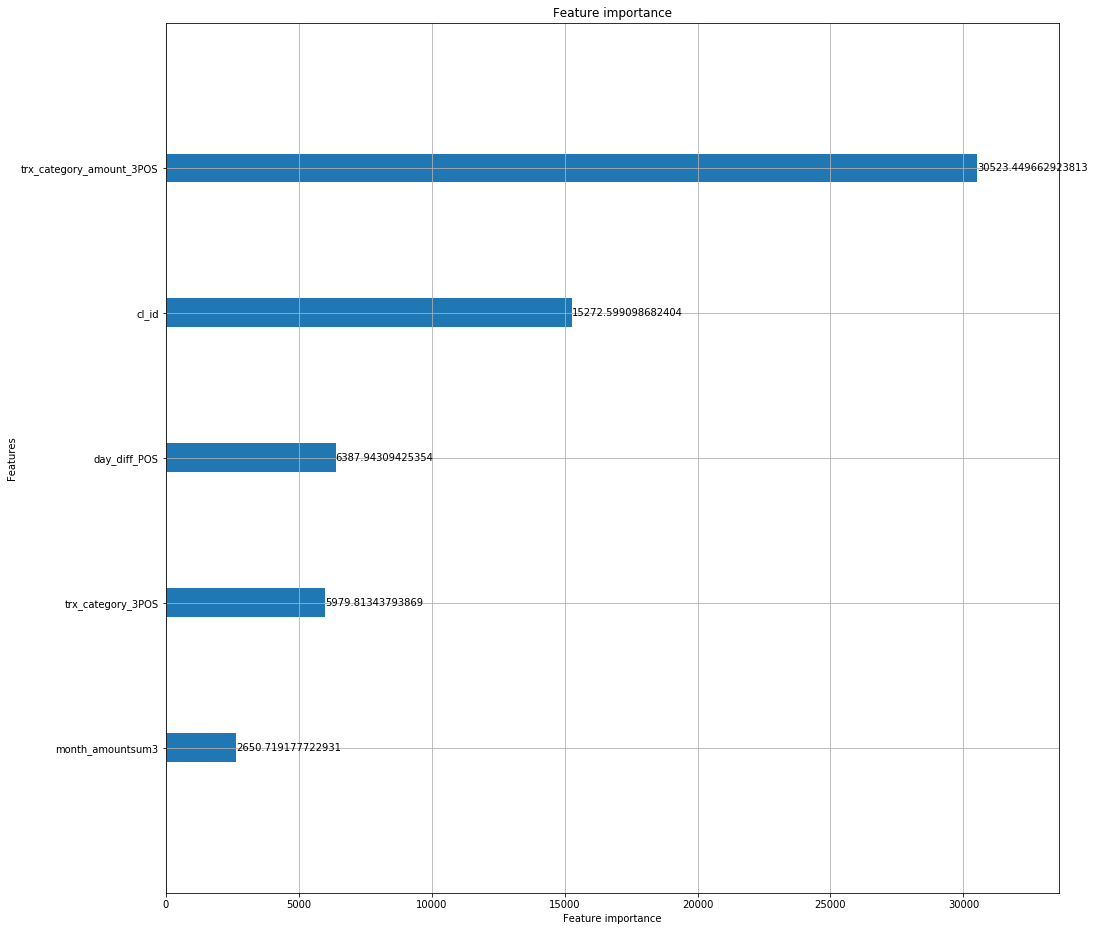

In [10]:
model = train(params, Dataset(X2, Y2), num_boost_round=770)
plot_importance(model, figsize=(16,16), importance_type='gain', max_num_features=5)

In [11]:
# Preparting features for test dataset
X_test = features(test).compute(get=get).sort_values('cl_id')

/home/light/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:150: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
/home/light/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'cl_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


## A

In [12]:
def ensemble_a(x, y):
    params = {'bagging_fraction': 0.55, 'bagging_freq': 2, 'colsample_bytree': 0.8, 
          'learning_rate': 0.01, 'max_bin': 255, 'max_depth': -1, 'metric': 'auc', 
          'min_data_in_leaf': 20, 'num_leaves': 16, 'objective': 'binary', 'reg_alpha': 0.4,
          'reg_lambda': 0.55, 'verbose': -1}

    model = train(params, Dataset(x, y), num_boost_round=770)
    k_model = CatBoostClassifier(eval_metric='AUC', iterations=750, logging_level='Silent', max_depth=7,
                                 learning_rate=0.02, random_seed=np.random.choice(10000), l2_leaf_reg=32
                                )
    k_model.fit(x, y)

    xg_model = XGBClassifier(n_estimators=770, learning_rate=0.01, subsample=0.55, colsample_bytree=0.8,
                      max_depth=7, min_child_weight=1, reg_alpha=0.4, reg_lambda=0.55
                     )

    xg_model.fit(x, y)

    a_pred = 0.4*model.predict(X_test)+0.4*xg_model.predict_proba(X_test)[:,1] + 0.2*k_model.predict_proba(X_test)[:,1]
    
    return a_pred

In [13]:
a_pred = ensemble_a(X2, Y2)

#### Pseudo labeling

In [14]:
valid_idx = np.where((a_pred>=0.95)|(a_pred<0.05))[0]
X3 = pd.concat([X2, X_test.iloc[valid_idx]])
Y3 = np.array(Y2.tolist()+ (a_pred[valid_idx]>=0.9).tolist())

In [15]:
X3.shape

(6085, 127)

In [16]:
a_pred = ensemble_a(X3, Y3)

In [17]:
pd.DataFrame({'_ID_': X_test.index, '_VAL_': a_pred}).to_csv('submission_a.csv', index=False)

In [18]:
a_pred[:5]

array([0.94384193, 0.8212521 , 0.70903157, 0.76372934, 0.97636015])

## B

In [19]:
params = {'bagging_fraction': 0.55, 'bagging_freq': 2, 'colsample_bytree': 0.5, 
          'learning_rate': 0.01, 'max_bin': 255, 'max_depth': -1, 'metric': 'rmse', 
          'min_data_in_leaf': 20, 'num_leaves': 16, 'objective': 'rmse', 
          'reg_alpha': 0.4,
          'reg_lambda': 0.55, 'verbose': -1
         }

_ = cv(params, Dataset(X2, np.log(1+Y2_reg)), verbose_eval=False,
       seed=200, num_boost_round=2000, early_stopping_rounds=100, stratified=False, nfold=10
      )
print(min(_['rmse-mean']))
print(np.array(_['rmse-mean']).argmin())

3.8265194013908603
654


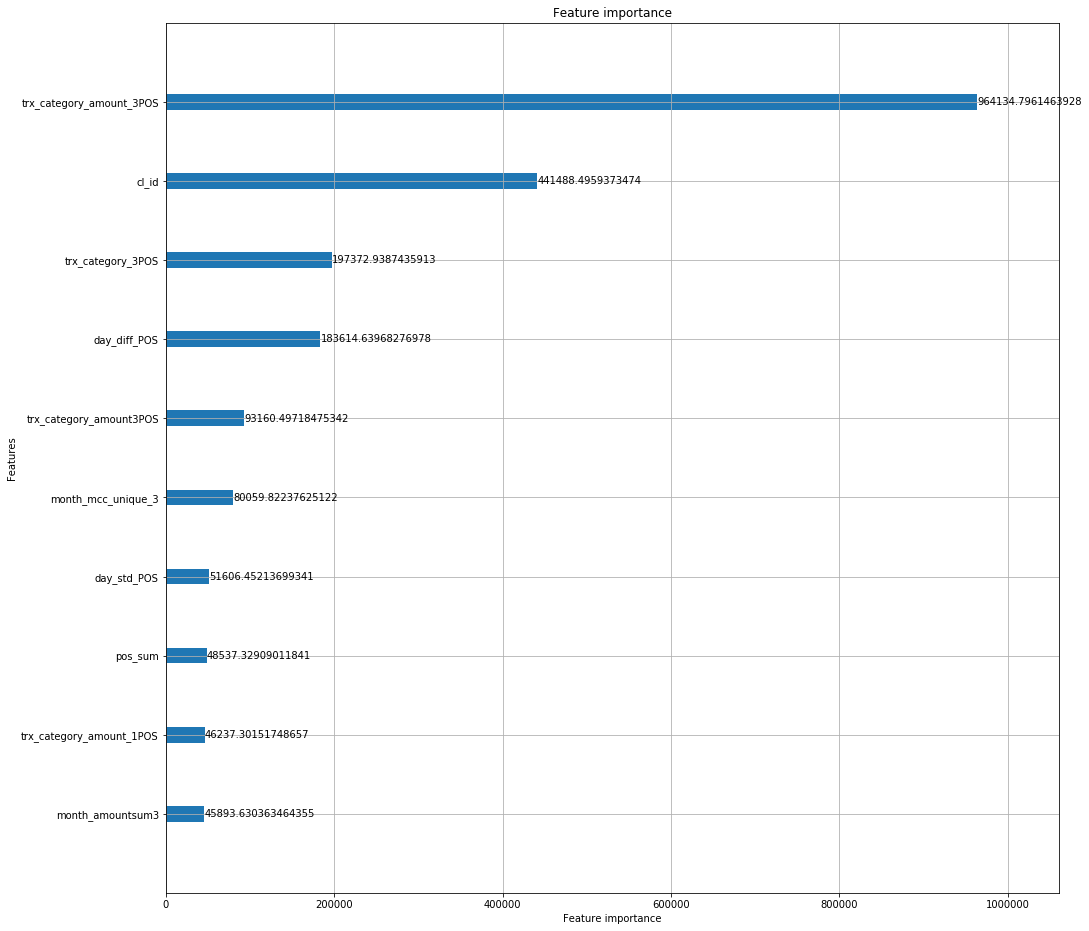

In [22]:
params = {'bagging_fraction': 0.55, 'bagging_freq': 2, 'colsample_bytree': 0.8, 
          'learning_rate': 0.01, 'max_bin': 255, 'max_depth': -1, 'metric': 'rmse', 
          'min_data_in_leaf': 20, 'num_leaves': 16, 'objective': 'rmse', 
          'reg_alpha': 0.4,
          'reg_lambda': 0.55, 'verbose': -1
         }
model = train(params, Dataset(X2, np.log(1+Y2_reg)), num_boost_round=770)
plot_importance(model, figsize=(16,16), importance_type='gain', max_num_features=10)

In [21]:
from xgboost import XGBRegressor

params = {'bagging_fraction': 0.55, 'bagging_freq': 2, 'colsample_bytree': 0.5, 
          'learning_rate': 0.01, 'max_bin': 255, 'max_depth': -1, 'metric': 'rmse', 
          'min_data_in_leaf': 20, 'num_leaves': 16, 'objective': 'rmse', 'reg_alpha': 0.4,
          'reg_lambda': 0.55, 'verbose': -1}

model = train(params, Dataset(X2, np.log(1+Y2_reg)), num_boost_round=770)
model_pred = np.exp(model.predict(X_test))-1

xgb = XGBRegressor(n_estimators=770, learning_rate=0.01, subsample=0.55, colsample_bytree=0.5,
                  max_depth=5, min_child_weight=1, reg_alpha=0.4, reg_lambda=0.75)
xgb.fit(X2, np.log(1+Y2_reg))
xgb_pred = np.exp(xgb.predict(X_test))-1

k = CatBoostRegressor(eval_metric='AUC', iterations=800, 
                      logging_level='Silent', max_depth=8, learning_rate=0.02,
                      l2_leaf_reg=12
                      )

k.fit(X2, np.log(1+Y2_reg))
k_pred = np.exp(k.predict(X_test))-1

b_pred = 0.4*model_pred+0.4*xgb_pred+0.2*k_pred

b_pred=np.clip(b_pred, 0, b_pred.max())
pd.DataFrame({'_ID_': X_test.index, '_VAL_': b_pred}).to_csv('submission_b.csv', index=False)